# Positive selection (dN/dS analyses) in protein-coding genes.
This Python Jupyter notebook is for Jesse Bloom's lecture in Genome Sciences 541.

## Running the notebook
You need Python 3.6+ to run this notebook.

To get a local instance, do the following:

1. Go to the [mybinder](https://mybinder.org/) instance at https://mybinder.org/v2/gh/jbloom/GenomeSciences541/gh-pages?filepath=positive_selection%2Fnotebook.ipynb

2. Download the following:
  - The notebook (`notebook.ipynb`) itself (you can just save it after opening mybinder instance).
  - The input sequences, [HA_alignment.fasta](HA_alignment.fasta).
  - The conda environment file, [../binder/environment.yml](../binder/environment.yml).
  
3. Install the conda environment (this requires you to have installed `conda`) and then activate it using the following commands:
   
          conda env create -f environment.yml
          conda activate GS541

4. Run the notebook in the conda environment.

## Background
In class, we went over Goldman-Yang style codon models on the white board.

[Yang et al, Genetics, 2000](https://www.genetics.org/content/155/1/431.long) describe the different types of model variants (Table 2 of the paper).
You should be familiar with:

  - M0
  - M1
  - M5
  - M7
  - M8
  
This models are implemented in the program [paml](http://web.mit.edu/6.891/www/lab/paml.html), which we will use in this notebook.
Note that similar (and often better) models are in [HyPhy](https://hyphy.org/), which also has a nice interface at [DataMonkey](https://www.datamonkey.org/). 
For actual research, you should strongly consider also using HyPhy / DataMonkey; but for this class we are using `paml` as it more simply illustrates the things that we are going to cover.

## Import Python modules
Here we import all the Python modules that we will use:

In [1]:
import glob
import os

import Bio.SeqIO
import Bio.Phylo
import Bio.Phylo.Applications
import Bio.Phylo.PAML.codeml

import matplotlib.pyplot as plt
plt.ion() # turn on interactive plotting

import pandas as pd

## Alignment and tree
We will analyze an alignment of H3 influenza hemagglutinin sequences.
Get some info and make a PHYLIP format version:

In [2]:
alignmentfile = 'HA_alignment.fasta'
alignment = list(Bio.SeqIO.parse(alignmentfile, 'fasta'))

print(f"Parsed {len(alignment)} sequences from {alignmentfile}.")

seqlen = len(alignment[0])
assert all(len(seq) == seqlen for seq in alignment)
print(f"Sequences are {seqlen} nucleotides long.")

alignmentfile_phylip = 'HA_alignment.phylip'
Bio.SeqIO.write(alignment, alignmentfile_phylip, 'phylip-sequential')

Parsed 25 sequences from HA_alignment.fasta.
Sequences are 1698 nucleotides long.


25

In order to use `paml`, we need to build a tree for these sequences.
We will do this using [RAxML](https://cme.h-its.org/exelixis/web/software/raxml/index.html).
You can run this program at command line:

In [3]:
!raxmlHPC -v



This is RAxML version 8.2.12 released by Alexandros Stamatakis on May 2018.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp   (KIT and HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
Charlie Taylor    (UF)



However, we will do it using the [BioPython wrapper](https://biopython.org/DIST/docs/api/Bio.Phylo.Applications-module.html).
Note that we are using a nucleotide model ([GTRCAT](https://cme.h-its.org/exelixis/resource/download/NewManual.pdf)); a common thing in codon model analyses of selection is to build a "good enough" tree using a faster nucleotide model and then analyze that tree with the codon model:

In [4]:
raxml_suffix = 'HA_tree'
raxml_cline = Bio.Phylo.Applications.RaxmlCommandline(
                sequences=alignmentfile_phylip,
                model='GTRCAT',
                name=raxml_suffix)
print(raxml_cline)

raxmlHPC -m GTRCAT -n HA_tree -p 10000 -s HA_alignment.phylip


RAxML doesn't overwrite existing results, so get rid of any existing output files:

In [5]:
for f in glob.glob(f"*.{raxml_suffix}"):
    os.remove(f)

Now run RAxML using the Python wrapper:

In [6]:
out = raxml_cline()
print(out[0])



Using BFGS method to optimize GTR rate parameters, to disable this specify "--no-bfgs" 



This is RAxML version 8.2.12 released by Alexandros Stamatakis on May 2018.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp   (KIT and HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
Charlie Taylor    (UF)


Alignment has 315 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 0.00%

RAxML rapid hill-climbing mode

Using 1 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
ML estimate of 25 per site rate categories

Likelihood of final tree will be evaluated and optimized under GAMMA

GAMMA Model para

Name of file with created tree; parse it:

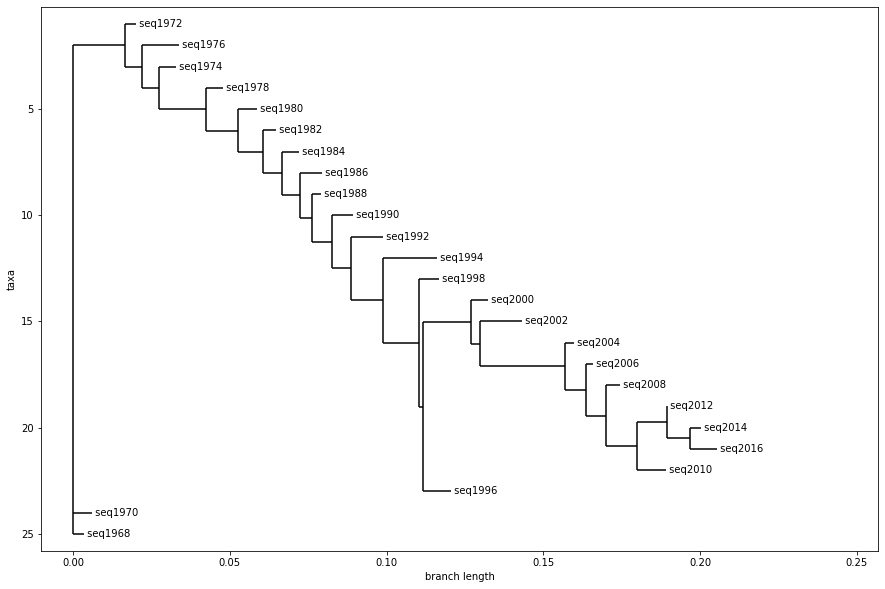

In [7]:
treefile = f"RAxML_bestTree.{raxml_suffix}"

tree = Bio.Phylo.read(treefile, 'newick')

fig = plt.figure(figsize=(15, 10))
axes = fig.add_subplot(1, 1, 1)
Bio.Phylo.draw(tree, axes=axes)

## Analyze with PAML
Now that we have an alignment and tree, we run PAML.
Again, we could do this at command line, but instead we will use the [BioPython wrapper](https://biopython.org/wiki/PAML).
See the [PAML docs](http://abacus.gene.ucl.ac.uk/software/pamlDOC.pdf) for meanings of the options set below.
Note that the `NSsites` variable maps to the codon models in [Yang et al, Genetics, 2000](https://www.genetics.org/content/155/1/431.long):

 - 0: M0, one $\omega$
 - 1: M1, $\omega < 1$ and $\omega = 1$
 - 5: M5, gamma distribution over $\omega$
 - 7: M7, beta distribution over $\omega$ between 0 and 1
 - 8: M8, like M7 but also one category with $\omega > 1$.

In [8]:
paml_results = 'paml_results.out'

cml = Bio.Phylo.PAML.codeml.Codeml(alignment=alignmentfile_phylip,
                            tree=treefile,
                            out_file=paml_results,
                            working_dir='.',
                            )

NSsites = [0, 1]

cml.set_options(verbose=9,
                noisy=9,
                runmode=0,
                seqtype=1,
                CodonFreq=0,  # makes it faster, for serious analysis use 2
                clock=0,
                aaDist=0,
                model=0,  # makes it faster, for serious analyses consider 1 or 2
                NSsites=NSsites,
                icode=0,
                Mgene=0,
                fix_kappa=0,
                kappa=2,
                fix_omega=0,
                omega=0.4,
                fix_alpha=1,
                alpha=0,
                Malpha=0,
                ncatG=4,
                fix_rho=1,
                rho=0,
                getSE=0,
                RateAncestor=0,
                Small_Diff=0.5e-6,
                method=0,
                fix_blength=2,  # probably you should use 1 for serious analysis but 2 is faster
                )
cml.print_options()

noisy = 9
verbose = 9
runmode = 0
seqtype = 1
CodonFreq = 0
ndata = None
clock = 0
aaDist = 0
aaRatefile = None
model = 0
NSsites = 0 1
icode = 0
Mgene = 0
fix_kappa = 0
kappa = 2
fix_omega = 0
omega = 0.4
fix_alpha = 1
alpha = 0
Malpha = 0
ncatG = 4
getSE = 0
RateAncestor = 0
Small_Diff = 5e-07
cleandata = None
fix_blength = 2
method = 0
rho = 0
fix_rho = 1


Run PAML:

In [9]:
cml.write_ctl_file()
results = cml.run()

Look at PAML results:

In [10]:
for codonmodel in NSsites:
    modelresults = results['NSsites'][codonmodel]
    print(f"\nResults for model M{codonmodel} ({modelresults['description']})")
    print(f"Log likelihood is {modelresults['lnL']}")
    for key, val in modelresults['parameters'].items():
          if key not in {'parameter list', 'branches'}:
              print(f"{key}: {val}")


Results for model M0 (one-ratio)
Log likelihood is -6220.678924
kappa: 4.94909
omega: 0.32545
dN: 0.0726
dS: 0.223

Results for model M1 (NearlyNeutral (2 categories))
Log likelihood is -6090.459401
kappa: 4.59785
site classes: {0: {'proportion': 0.83181, 'omega': '0.00000'}, 1: {'proportion': 0.16819, 'omega': '1.00000'}}


## Questions for homework

1. In the example above, we ran PAML for just the M0 and M1 model (this is set via the `NSsites` variable).
   Also run it for the M5, M7, and M8 models.
   Compare the log likelihoods for these models and interpret the results.
   Compare the omega values for these models and interpret the results.
   In particular, what does comparing the M7 and M8 models tell you about whether there are sites under positive selection?
   If there are such sites, roughly how many?
   
2. For the M5 model, use the shape parameters returned to plot the gamma distribution over $\omega$ (these are the alpha and beta parameters, `a` and `b`).
   Give some interpretation to the shape of this distribution.
   
3. As described in the [PAML docs](http://abacus.gene.ucl.ac.uk/software/pamlDOC.pdf), the `rst` file created by PAML will include information on which sites appear to be positively selected.
   What are the positively selected sites under the M5 and M8 models, and how much overlap is there in these sets of sites?
 
4. Repeat the analysis using the larger alignment in [HA_alignment_big.fasta](HA_alignment_big.fasta). 
   Do any of the results above change in a meaningful way with this bigger alignment?